In [74]:
import csv
import numpy as np
import pandas as pd

from keras.models import load_model
from sklearn.externals import joblib

# Load model, best weights and scaler
model = load_model('model.h5')
model.load_weights("weights.hdf5")
scaler = joblib.load("scaler.save")

In [21]:
df = pd.read_csv("poloniex_usdt_btc_20170101_weightedAverage_300.csv", sep=";", index_col=None)

In [22]:
df.tail()

,date,weightedAverage
187724,1539546000,6401.000000
187725,1539546300,6401.000000
187726,1539546600,6401.064122
187727,1539546900,6402.134046
187728,1539547200,6403.722071


In [23]:
df_values = df.values
timestamps = df_values[:, 0]
dataset = df_values[:, 1].astype("float")

In [24]:
samples_num = df.shape[0]
test_split = 0.1
dataset_test = df[int(samples_num * (1 - test_split)):]
print(dataset_test.shape)

(18773, 2)


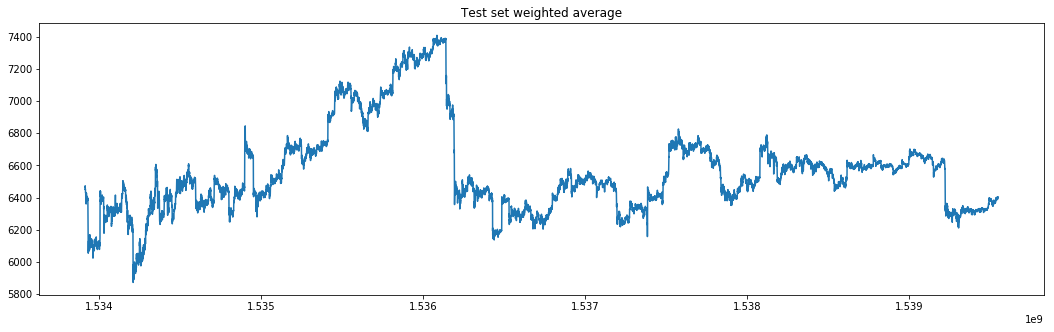

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(18, 5))
plt.title('Test set weighted average')
plt.plot(dataset_test[['date']], dataset_test[['weightedAverage']])
plt.show()

In [26]:
data = np.array(dataset_test[['weightedAverage']])
data = scaler.transform(data)
print(data[0])
print(data.shape)

[0.27597285]
(18773, 1)


In [75]:
# Predict next 20 candles
prediction_range = 20
prediction_lookback = 40

predictions = np.zeros(prediction_lookback)

for interval in range(prediction_lookback//prediction_range,data.shape[0]//prediction_range):
    # Prediction from last 20 candles
    lasts = data[prediction_range*interval-prediction_lookback:prediction_range*interval]

    for days in range(prediction_range):
        d = lasts[-prediction_lookback:] 
#         print(d.shape)
        d = np.expand_dims(d, axis=0) # NN waits for array, we use just 1 day as input
        next = model.predict(d, batch_size=1)
        lasts = np.append(lasts, next, axis=0) # Add prediction to known days
        next = next.reshape(1,)[0]
        predictions = np.append(predictions, [next], axis=0)

In [71]:
print(data.shape)
print(predictions.shape)
print(prediction_lookback,data.shape[0]//prediction_range)

(18000, 1)
(18000,)
40 900


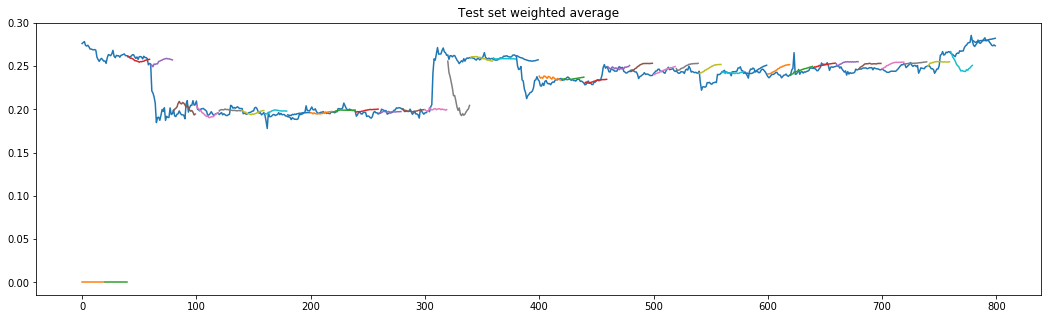

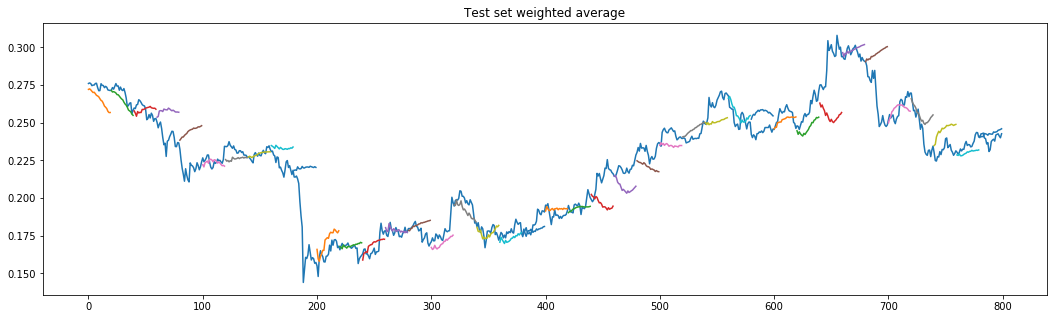

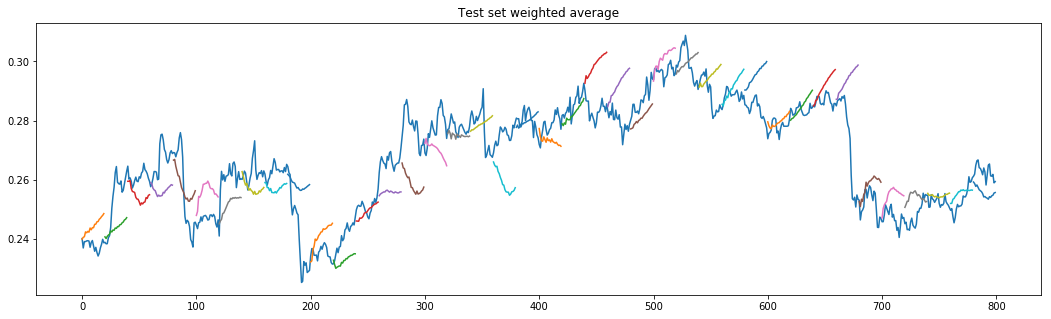

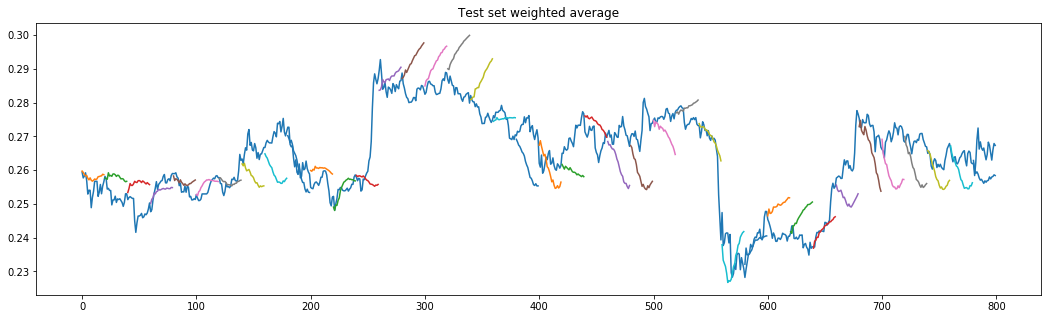

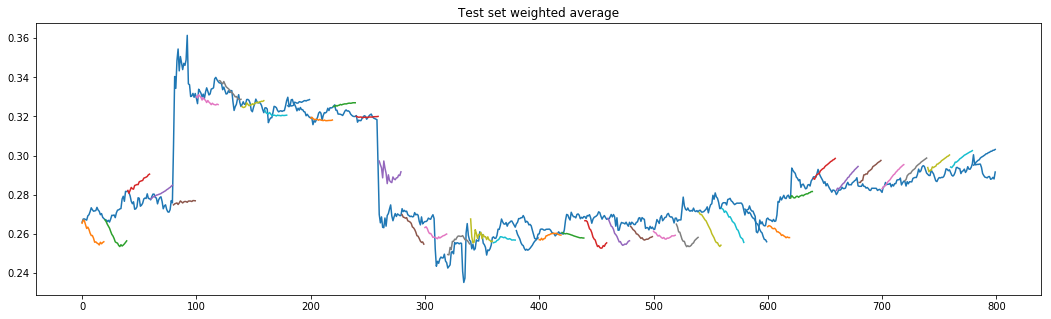

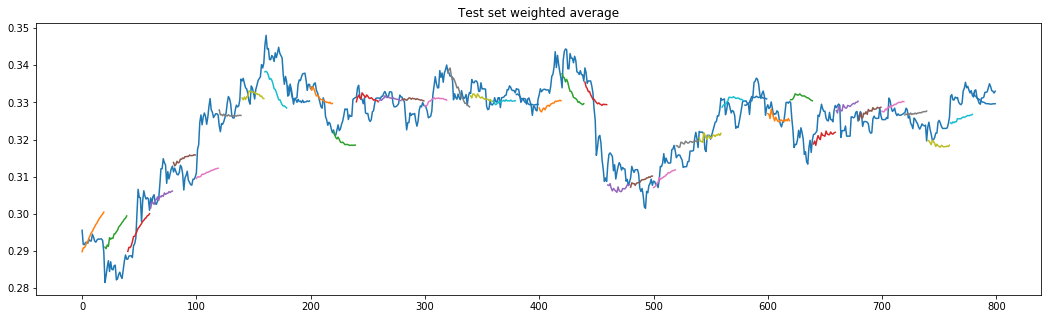

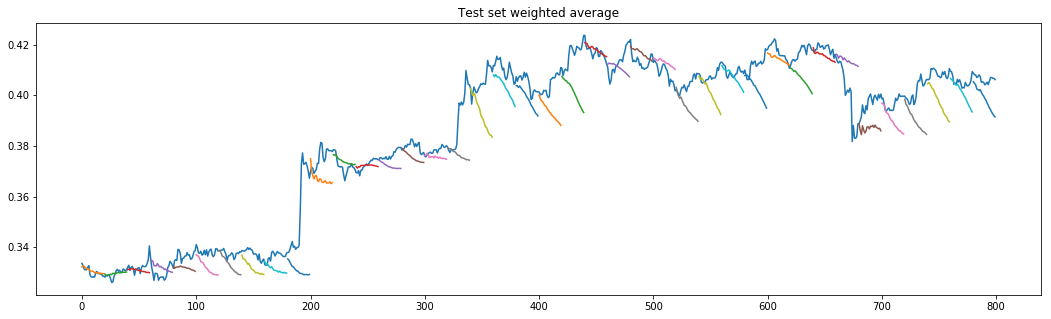

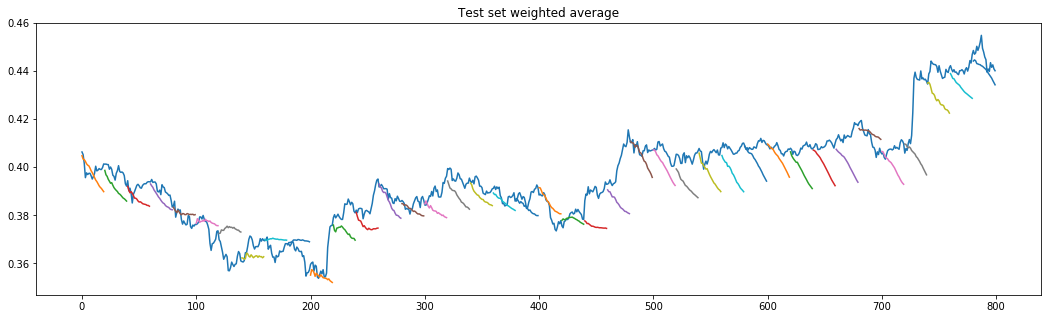

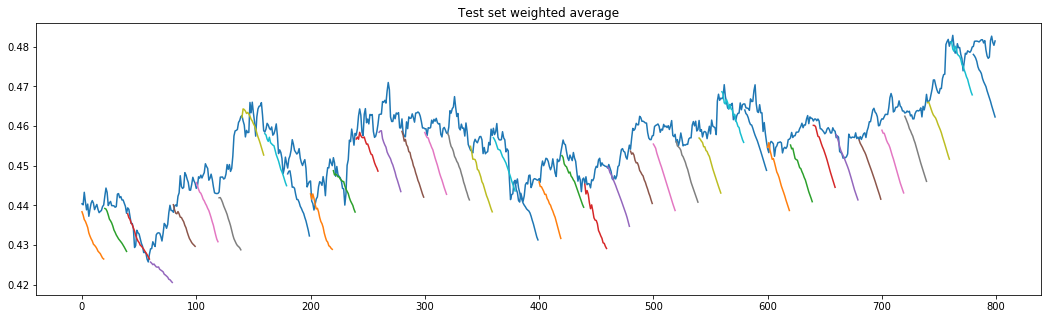

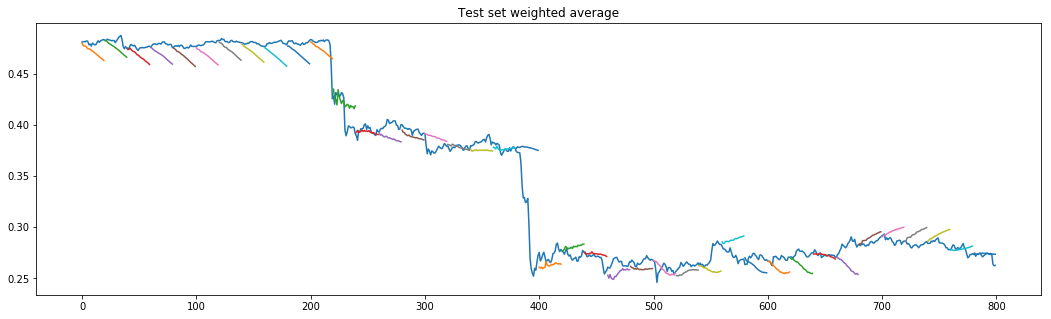

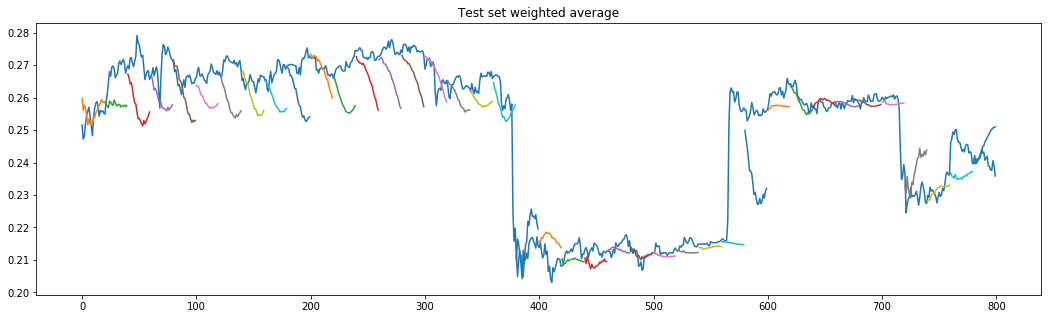

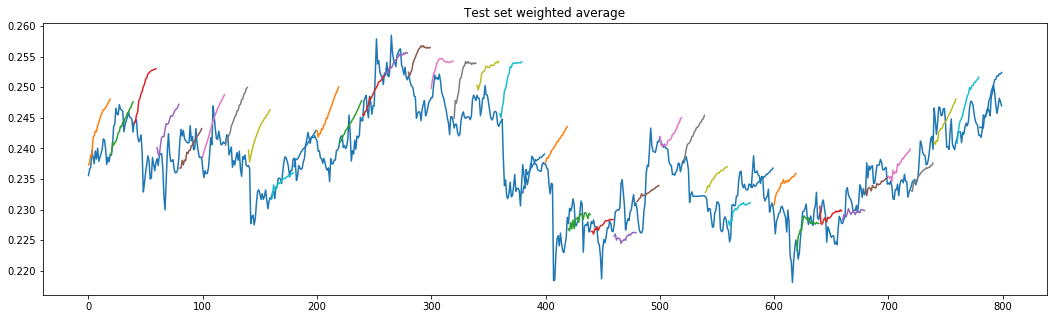

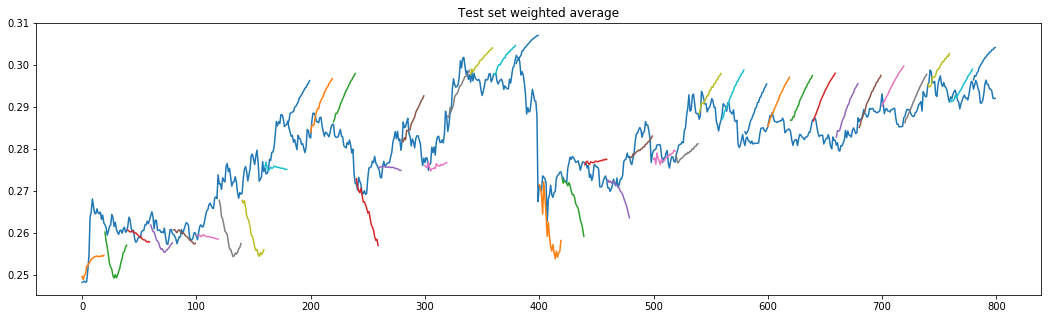

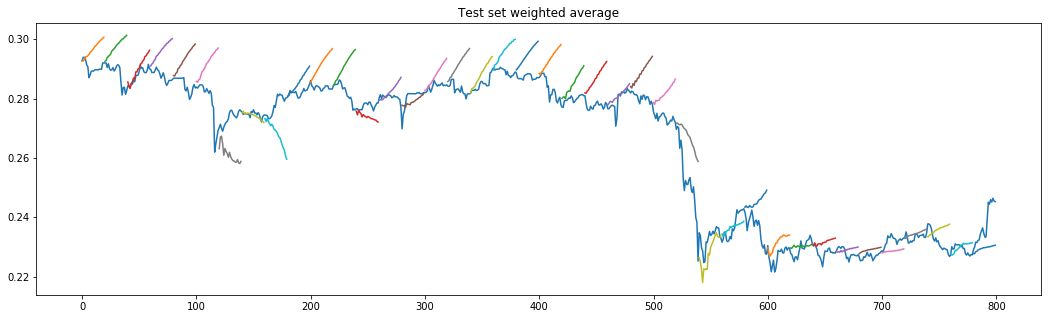

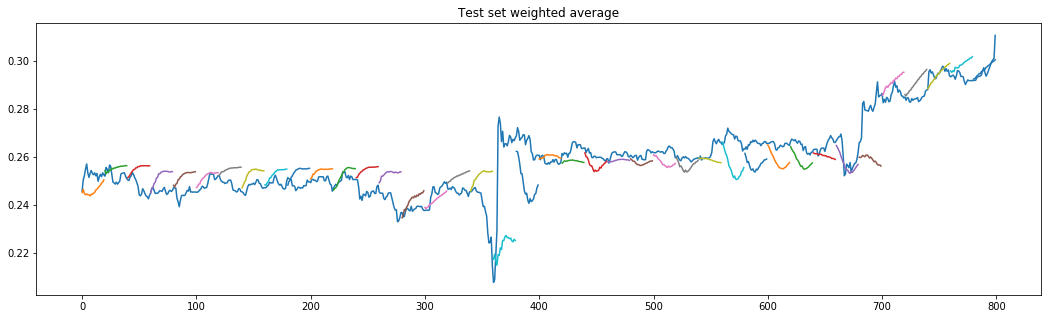

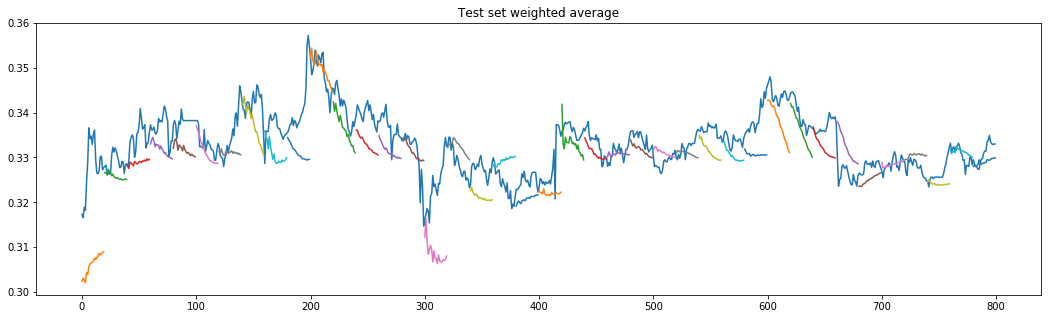

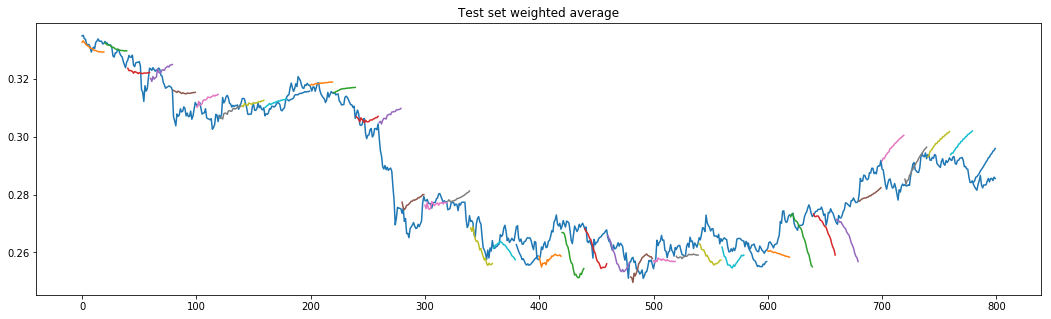

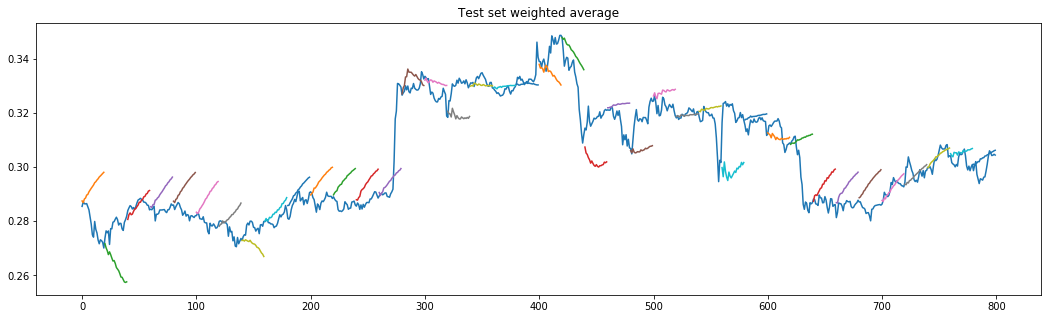

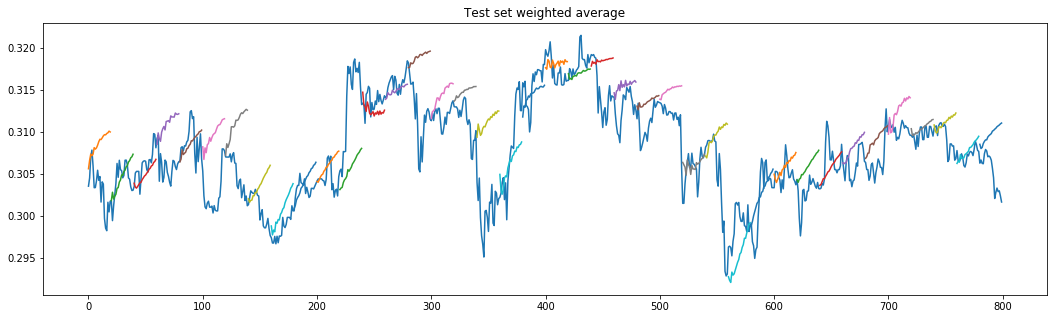

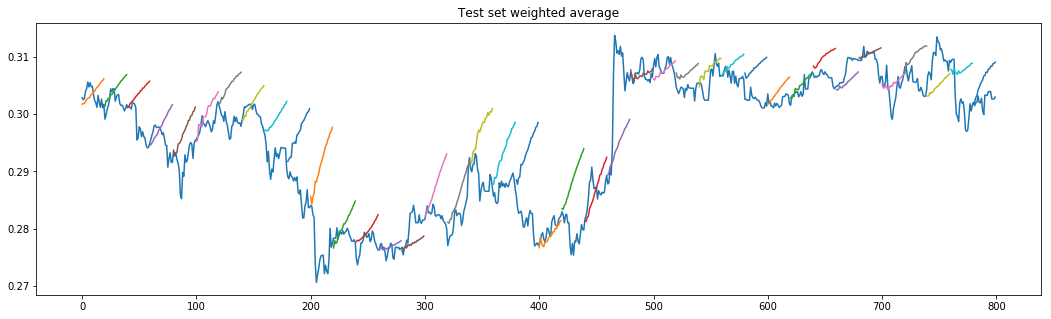

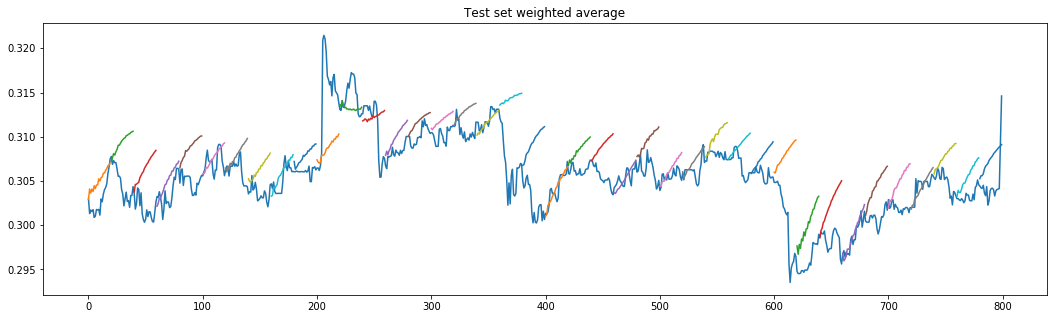

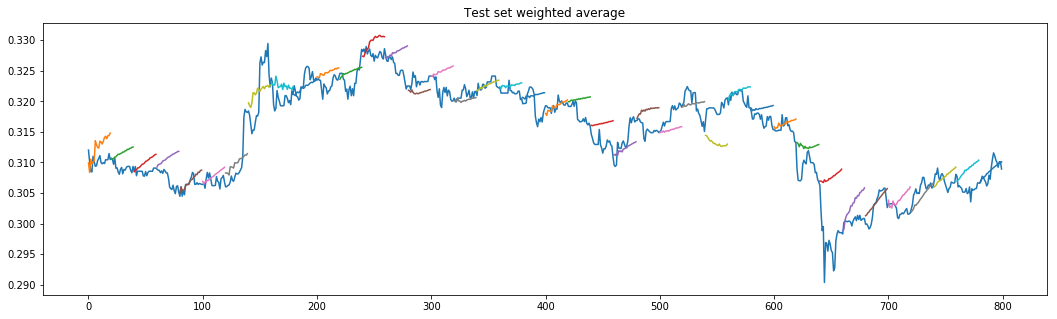

In [76]:
plot_length = 800
number_of_plots = predictions.shape[0] // plot_length

for i in range(number_of_plots):
    
    plt.figure(figsize=(18, 5))
    plt.title('Test set weighted average')
    start = i*plot_length
    end = (i+1)*plot_length
    plt.plot(data[start:end])
    for k in range(start, end, prediction_range):
        plt.plot([None for i in range(k-start)] + [x for x in predictions[k:k+prediction_range]])
    plt.show()

# plt.figure(figsize=(18, 5))
# plt.title('Test set weighted average')
# plt.plot(data[-500:-200])
# for k in range(-500, -200, prediction_range):
#     plt.plot([None for i in range(k+500)] + [x for x in predictions[k:k+prediction_range]])
# plt.show()

# plt.figure(figsize=(18, 5))
# plt.title('Test set weighted average')
# plt.plot(data[-1500:-1300])
# for k in range(-1500, -1300, prediction_range):
#     plt.plot([None for i in range(k+1500)] + [x for x in predictions[k:k+prediction_range]])
# plt.show()


# plt.figure(figsize=(18, 5))
# plt.title('Test set weighted average')
# plt.plot(data[-3000:-2800])
# for k in range(-3000, -2800, prediction_range):
#     plt.plot([None for i in range(k+3000)] + [x for x in predictions[k:k+prediction_range]])
# plt.show()